In [1]:
import os
import glob
import napari
import pandas as pd
import numpy as np
import mahotas as mh

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240329/240325_ARMC5KO_BaselineIF"
image_dir = os.path.join(data_dir,"20240329_104049_713/OME-TIFF-MIP")
label_image_dir = os.path.join(data_dir,"20240329_104049_713/SEGMENTATION")

#data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240402/240329_ARMC5KO_BaselineIF"
#image_dir = os.path.join(data_dir,"20240402_174743_309/OME-TIFF-MIP")
#label_image_dir = os.path.join(data_dir,"20240402_174743_309/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hek_IF"
illum_corr_file = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240329/240325_ARMC5KO_BaselineIF/ILLUMCORR/illumination_correction.pkl"

01-Aug-24 21:24:10 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [3]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240325_ARMC5KO_BaselineIF_longlayout.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['Well_name'] = plate_layout['Well'].apply(lambda x: pad_well_names(x))

## Apply illumination correction

Load illumination correction object

In [4]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [5]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata['well_name'] = image_metadata['filename_ome_tiff'].str.extract(r'Well([A-Z]\d{2})_Channel')
image_metadata.columns

Index(['n_pixels_y', 'n_pixels_x', 'objective_name', 'pixel_size_microns',
       'field_id', 'timepoint_id', 'filename_ome_tiff', 'acquisition_time_rel',
       'stage_y_abs', 'stage_x_abs', 'stage_z_n', 'acquisition_time_abs',
       'standard_field_id', 'metadata_string_acquisition_0',
       'metadata_string_acquisition_1', 'metadata_string_acquisition_2',
       'metadata_string_acquisition_3', 'well_name'],
      dtype='object')

In [6]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="well_name", right_on="Well_name")

In [7]:
image_metadata_annotated.query(
    "Cell == 'HEK293 ARMC5 KO 2B6' and Primary == 'pSer5 Pol II' and field_id == 1")

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,...,metadata_string_acquisition_0,metadata_string_acquisition_1,metadata_string_acquisition_2,metadata_string_acquisition_3,well_name,Well,Cell,Primary,Secondary,Well_name
32,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellK06_ChannelNone,488,XXX,405_Seq0053_0001.o...",10581.901028,10603.790476,29877.6,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,K06,K6,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,K06
80,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellH06_ChannelNone,488,XXX,405_Seq0034_0001.o...",6792.510208,-2937.247619,29881.0,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,H06,H6,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,H06
160,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellH05_ChannelNone,488,XXX,405_Seq0035_0001.o...",6991.939376,-2932.023810,34377.8,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,H05,H5,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,H05
208,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellN05_ChannelNone,488,XXX,405_Seq0071_0001.o...",14161.334715,24149.733333,34370.7,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,N05,N5,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,N05
240,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellN06_ChannelNone,488,XXX,405_Seq0070_0001.o...",13962.847150,24144.414286,29874.1,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,N06,N6,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,N06
432,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellK05_ChannelNone,488,XXX,405_Seq0052_0001.o...",10382.644959,10608.752381,34374.4,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,K05,K5,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,K05
640,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellE06_ChannelNone,488,XXX,405_Seq0016_0001.o...",3200.661509,-16478.252381,29884.6,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,E06,E6,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,E06
992,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellE05_ChannelNone,488,XXX,405_Seq0015_0001.o...",3002.248841,-16473.166667,34381.4,...,Plane #1:\n Name: None\n Component Count: 1\n ...,Plane #2:\n Name: 488\n Component Count: 1\n M...,Plane #3:\n Name: XXX\n Component Count: 1\n M...,Plane #4:\n Name: 405\n Component Count: 1\n M...,E05,E5,HEK293 ARMC5 KO 2B6,pSer5 Pol II,Anti-rat 488,E05


## Save Examples

In [8]:
example_images = image_metadata_annotated.query("field_id == 4 & Primary!='None'")[['filename_ome_tiff','Primary','Secondary','Cell','well_name']]
example_images['new_filename'] = example_images['Cell'] + '_' + '_' + example_images['Primary'] + '_' + example_images['Secondary'] + '_' + example_images['well_name'] + '.png'
example_images['new_filename_overlay'] = example_images['Cell'] + '_' + example_images['Primary'] + '_' + example_images['Secondary'] + '_' + example_images['well_name'] + '_nuclei.png'
example_images['filename_segmentation'] = 'nuclei_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group'] = example_images['Primary']

In [9]:
example_images

,filename_ome_tiff,Primary,Secondary,Cell,well_name,new_filename,new_filename_overlay,filename_segmentation,intensity_rescaling_group
19,"WellI04_ChannelNone,488,XXX,405_Seq0039_0004.o...",Total Pol II,Anti-mouse 488,HEK293 parental,I04,HEK293 parental__Total Pol II_Anti-mouse 488_I...,HEK293 parental_Total Pol II_Anti-mouse 488_I0...,"nuclei_WellI04_ChannelNone,488,XXX,405_Seq0039...",Total Pol II
35,"WellK06_ChannelNone,488,XXX,405_Seq0053_0004.o...",pSer5 Pol II,Anti-rat 488,HEK293 ARMC5 KO 2B6,K06,HEK293 ARMC5 KO 2B6__pSer5 Pol II_Anti-rat 488...,HEK293 ARMC5 KO 2B6_pSer5 Pol II_Anti-rat 488_...,"nuclei_WellK06_ChannelNone,488,XXX,405_Seq0053...",pSer5 Pol II
51,"WellG07_ChannelNone,488,XXX,405_Seq0030_0004.o...",pSer2 Pol II,Anti-rat 488,HEK293 ARMC5 KO 1A3,G07,HEK293 ARMC5 KO 1A3__pSer2 Pol II_Anti-rat 488...,HEK293 ARMC5 KO 1A3_pSer2 Pol II_Anti-rat 488_...,"nuclei_WellG07_ChannelNone,488,XXX,405_Seq0030...",pSer2 Pol II
67,"WellK08_ChannelNone,488,XXX,405_Seq0055_0004.o...",pSer2 Pol II,Anti-rat 488,HEK293 ARMC5 KO 2B6,K08,HEK293 ARMC5 KO 2B6__pSer2 Pol II_Anti-rat 488...,HEK293 ARMC5 KO 2B6_pSer2 Pol II_Anti-rat 488_...,"nuclei_WellK08_ChannelNone,488,XXX,405_Seq0055...",pSer2 Pol II
83,"WellH06_ChannelNone,488,XXX,405_Seq0034_0004.o...",pSer5 Pol II,Anti-rat 488,HEK293 ARMC5 KO 2B6,H06,HEK293 ARMC5 KO 2B6__pSer5 Pol II_Anti-rat 488...,HEK293 ARMC5 KO 2B6_pSer5 Pol II_Anti-rat 488_...,"nuclei_WellH06_ChannelNone,488,XXX,405_Seq0034...",pSer5 Pol II
...,...,...,...,...,...,...,...,...,...
1107,"WellF07_ChannelNone,488,XXX,405_Seq0021_0004.o...",pSer2 Pol II,Anti-rat 488,HEK293 parental,F07,HEK293 parental__pSer2 Pol II_Anti-rat 488_F07...,HEK293 parental_pSer2 Pol II_Anti-rat 488_F07_...,"nuclei_WellF07_ChannelNone,488,XXX,405_Seq0021...",pSer2 Pol II
1123,"WellC04_ChannelNone,488,XXX,405_Seq0001_0004.o...",Total Pol II,Anti-mouse 488,HEK293 parental,C04,HEK293 parental__Total Pol II_Anti-mouse 488_C...,HEK293 parental_Total Pol II_Anti-mouse 488_C0...,"nuclei_WellC04_ChannelNone,488,XXX,405_Seq0001...",Total Pol II
1139,"WellG06_ChannelNone,488,XXX,405_Seq0029_0004.o...",pSer5 Pol II,Anti-rat 488,HEK293 ARMC5 KO 1A3,G06,HEK293 ARMC5 KO 1A3__pSer5 Pol II_Anti-rat 488...,HEK293 ARMC5 KO 1A3_pSer5 Pol II_Anti-rat 488_...,"nuclei_WellG06_ChannelNone,488,XXX,405_Seq0029...",pSer5 Pol II
1155,"WellM03_ChannelNone,488,XXX,405_Seq0062_0004.o...",Total Pol II,Anti-mouse 488,HEK293 ARMC5 KO 1A3,M03,HEK293 ARMC5 KO 1A3__Total Pol II_Anti-mouse 4...,HEK293 ARMC5 KO 1A3_Total Pol II_Anti-mouse 48...,"nuclei_WellM03_ChannelNone,488,XXX,405_Seq0062...",Total Pol II


In [10]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [11]:
%%capture
example_images_grouped = example_images.query("Cell == 'HEK293 ARMC5 KO 2B6'").groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        IF_array = aics_image.get_image_data('YX',Z=0,C=1,T=0)
        upper_rescale_value.append(np.quantile(IF_array,0.99))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [12]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [13]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=1,T=0)
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)


In [14]:
corresponding_secondaries = upper_rescale_values_df.merge(
    image_metadata_annotated.drop_duplicates(['Primary','Secondary'])[['Primary','Secondary']],
    left_on='intensity_rescaling_group',right_on='Primary').drop('Primary',axis=1)
corresponding_secondaries

,intensity_rescaling_group,upper_rescale_value,Secondary
0,Total Pol II,878.0,Anti-mouse 488
1,pSer2 Pol II,1254.0,Anti-rat 488
2,pSer5 Pol II,2732.0,Anti-rat 488


In [22]:
secondary_only = image_metadata_annotated.query("field_id == 4 & Primary == 'None'")[['filename_ome_tiff','Primary','Secondary','Cell','well_name']].merge(
    corresponding_secondaries,
    left_on='Secondary',
    right_on='Secondary')
secondary_only['filename_segmentation'] = 'nuclei_' + secondary_only['filename_ome_tiff']
secondary_only['new_filename'] = secondary_only['Cell'] + '_' + secondary_only['Primary'] + '_' + secondary_only['Secondary'] + '_' + secondary_only['well_name'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '.png'
secondary_only['new_filename_overlay'] = secondary_only['Cell'] + '_' + secondary_only['Primary'] + '_' + secondary_only['Secondary'] + '_' + secondary_only['well_name'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '_nuclei.png'
secondary_only

,filename_ome_tiff,Primary,Secondary,Cell,well_name,intensity_rescaling_group,upper_rescale_value,filename_segmentation,new_filename,new_filename_overlay
0,"WellF09_ChannelNone,488,XXX,405_Seq0019_0004.o...",None,Anti-mouse 488,HEK293 parental,F09,Total Pol II,878.0,"nuclei_WellF09_ChannelNone,488,XXX,405_Seq0019...",HEK293 parental_None_Anti-mouse 488_F09_rescal...,HEK293 parental_None_Anti-mouse 488_F09_rescal...
1,"WellC09_ChannelNone,488,XXX,405_Seq0006_0004.o...",None,Anti-mouse 488,HEK293 parental,C09,Total Pol II,878.0,"nuclei_WellC09_ChannelNone,488,XXX,405_Seq0006...",HEK293 parental_None_Anti-mouse 488_C09_rescal...,HEK293 parental_None_Anti-mouse 488_C09_rescal...


In [23]:
%%capture
for index, row in secondary_only.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=1,T=0)
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)

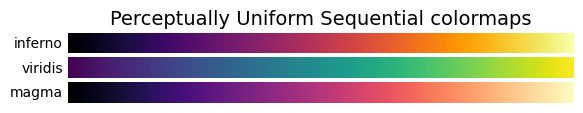

In [24]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))

In [25]:
example_dir

PosixPath('/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240329/240325_ARMC5KO_BaselineIF/20240329_104049_713/EXAMPLES/RGB')

In [26]:
aics_image.channel_names

['None', '488', 'XXX', '405']